01/03/2024 - This notebook is to port Paco's new 3 Gpc/h Quijote HR simulations into ltu-cmass.

In [4]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from os.path import join
import Pk_library as PKL
import h5py
mpl.rcParams['figure.dpi'] = 300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'

In [6]:
from colossus.halo import mass_so
from colossus.cosmology import cosmology
from cmass.utils import cosmo_to_astropy

cosmo = [0.3175, 0.049, 0.6711, 0.9624, 0.834] 
astropy_cosmo = cosmo_to_astropy(
    cosmo# fiducial Quijote cosmology
)

colossus_cosmo = cosmology.fromAstropy(astropy_cosmo, sigma8=cosmo[4], ns=cosmo[3], cosmo_name = 'my_cosmo')

In [24]:
datadir = '/anvil/projects/x-phy240043/3Gpc/fiducial_cosmo'
snapz = {0: 0.4, 1: 0.5, 2: 0.6}

snapnum = 2
z = snapz[snapnum]
a = 1/(1+z)
mass_type = 'rockstar_200c'
snapfile = join(datadir, f'out_{snapnum}_pid.list')
rockstar = np.loadtxt(snapfile)
with open(snapfile, 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
hpos = rockstar[:, header.index('X'):header.index('Z')+1]
hvel = rockstar[:, header.index('VX'):header.index('VZ')+1]
hrs = rockstar[:, header.index('Rs')]
if mass_type == 'rockstar_vir':
    hmass = rockstar[:, header.index('Mvir')]  # Halo masses in Msun/h
    hr = rockstar[:, header.index('Rvir')]
elif mass_type == 'rockstar_200c':
    hmass = rockstar[:, header.index('M200c')]  # halo masses in Msun/h
    hr = mass_so.M_to_R(hmass, z, '200c')  # halo physical radius in kpc/h
    hr /= a  # convert to comoving radius
    
hmass = np.log10(hmass)
hconc = hr/hrs

/tmp/ipykernel_2103789/1990185358.py:25: RuntimeWarning: divide by zero encountered in log10
  hmass = np.log10(hmass)


In [25]:
mmin = np.log10(5e12)

m = hmass > mmin
hmass = hmass[m]
hvel = hvel[m]
hpos = hpos[m]
hr = hr[m]
hconc = hconc[m]

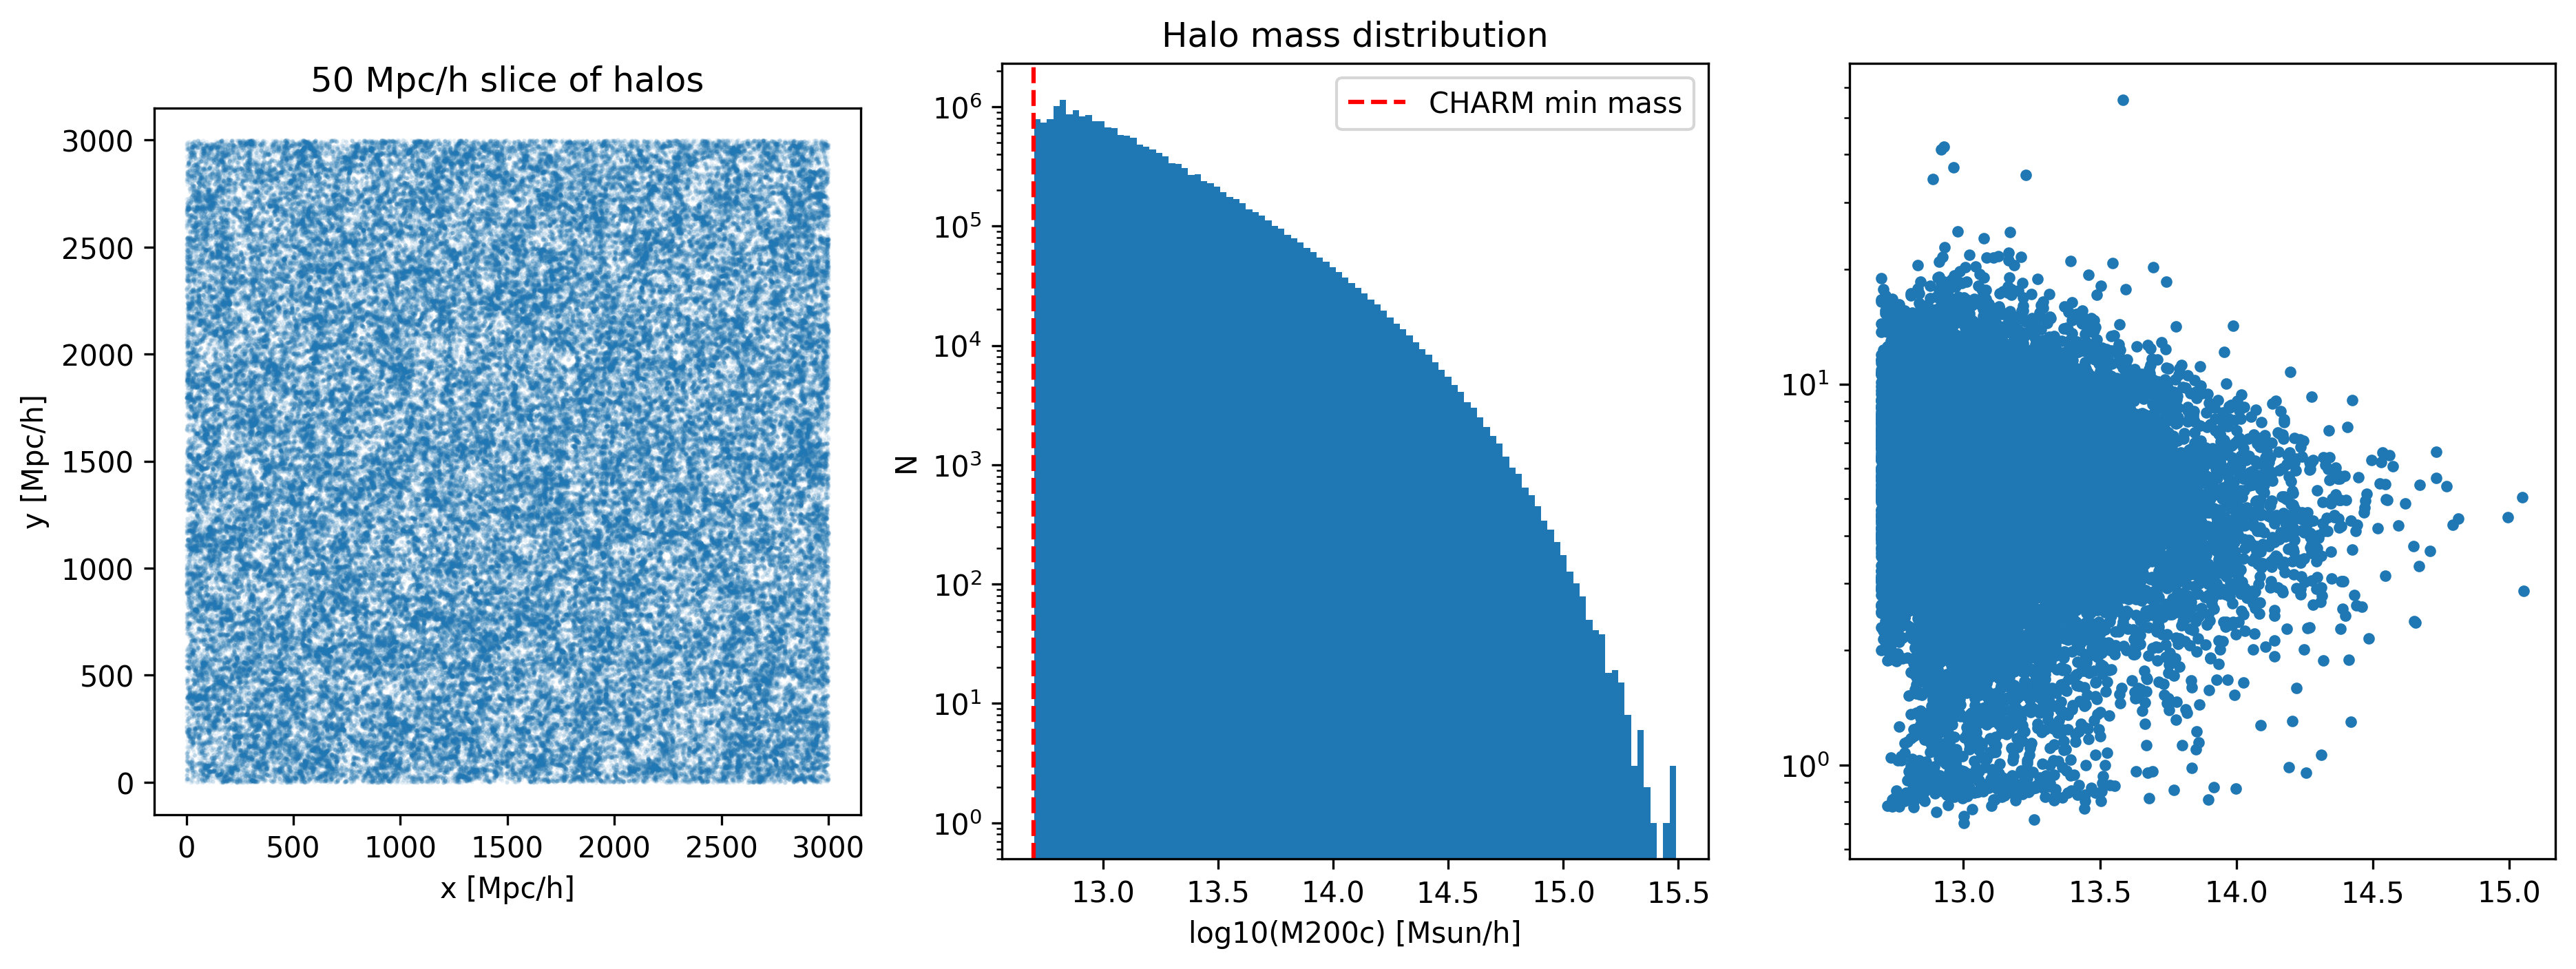

In [26]:
m = hpos[:, 0] < 50
x = hpos[m]
f, axs = plt.subplots(1, 3, figsize=(15, 5))

ax = axs[0]
ax.plot(x[:, 1], x[:, 2], '.', markersize=1, alpha=0.1)
ax.set(xlabel='x [Mpc/h]', ylabel='y [Mpc/h]', title='50 Mpc/h slice of halos')
ax.set_aspect('equal')

ax = axs[1]
ax.hist(hmass, bins=100)
ax.axvline(mmin, color='r', ls='--', label='CHARM min mass')
ax.semilogy()
ax.set(xlabel='log10(M200c) [Msun/h]',
       ylabel='N', title='Halo mass distribution')
ax.legend()

ax = axs[2]
ax.plot(hmass[::1000], hconc[::1000], '.')
ax.semilogy();


In [27]:
from cmass.bias.rho_to_halo import save_snapshot

savepath = '/anvil/scratch/x-mho1/cmass-ili/quijote3gpch/nbody/L3000-N384/0'
z = snapz[snapnum]
a = 1/(1+z)
meta = {'concentration': hconc}

print(f'Saving to {savepath} at a={a:.06f}')
save_snapshot(savepath, a, hpos, hvel, hmass, **meta)

Saving to /anvil/scratch/x-mho1/cmass-ili/quijote3gpch/nbody/L3000-N384/0 at a=0.625000
